In [1]:
import os
import sys
import pdb
import torch

print("Is CUDA available? {}".format(torch.cuda.is_available()))

Is CUDA available? False


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split

sys.path.insert(0, '..')

## Generating synthetic data

In [3]:
def plot_func(x, y, quantiles=None, quantile_labels=None, max_show=5000,
              shade_color="", method_name="", title="", filename=None, save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    quantiles : numpy array, the estimated prediction. It may be the conditional mean,
                or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if quantiles is not None:
        quantiles = quantiles[:max_show]
    
    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds], y_[inds], 'k.', alpha=.2, markersize=10, fillstyle='none')
    
    if quantiles is not None:
        num_quantiles = quantiles.shape[1]
    else:
        num_quantiles = 0  
    
    if quantile_labels is None:
        pred_labels = ["NA"] * num_quantiles
    for k in range(num_quantiles):
        label_txt = 'Quantile {q}'.format(q=quantile_labels[k])
        plt.plot(x_[inds], quantiles[inds,k], '-', lw=2, alpha=0.75, label=label_txt)
    
    plt.ylim([-2, 20])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/lib/python3/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


Text(0.5, 1.0, 'Test data (visualize outliers)')

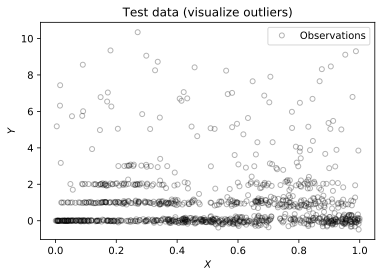

In [4]:
from chr import models
from chr import coverage

np.random.seed(123)

data_model = models.Model_Ex1(symmetry=0) 

# Generate training samples
n_train = 2000
X_data, Y_data = data_model.sample(n_train)

# Generate test samples
n_test = 1000
X_test, Y_test = data_model.sample(n_test)

# Plot data
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'lightblue'

# maximal number of testpoints to plot
max_show = 1000

# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(X_test[:,0], Y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')

# display the test data without outliers (zoom in)
#plot_func(X_test[:,0], Y_test, title="Test data (zoom in)")

## Training a conditional density estimator 

We will train a quantile-based piece-wise constant conditional density estimator using a deep neural network.

In [5]:
from chr.black_boxes import QNet, QRF
from chr.black_boxes_r import QBART

# Which quantiles should we estimate?
grid_quantiles = np.arange(0.01,1.0,0.01)

# Which black-box model?
bbox_name = "NNet"

if bbox_name=="NNet":
    bbox = QNet(grid_quantiles, 1, no_crossing=True, batch_size=1000, dropout=0.1,
                num_epochs=10000, learning_rate=0.0005, num_hidden=256, calibrate=0)
elif bbox_name=="RF":
    bbox = QRF(grid_quantiles, n_estimators=100, min_samples_leaf=50, random_state=2020)
elif bbox_name=="BART":
    bbox = QBART(grid_quantiles, random_state=2020)

loss_stats = bbox.fit(X_data, Y_data)

Training with 2000 samples and 1 features.


  0%|          | 0/10000 [00:00<?, ?it/s]

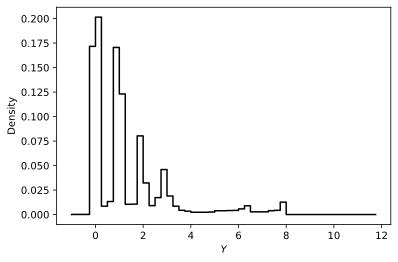

In [6]:
from chr.histogram import Histogram
from chr.utils import plot_histogram

# Predict the quantiles
Q_test = bbox.predict(X_test)

# Discrete grid for density estimator
grid_histogram = np.arange(-1,12,0.25)

# Initialize conditional density estimator
hist = Histogram(grid_quantiles, grid_histogram)

# Estimate conditional density for test points
histogram_test = hist.compute_histogram(Q_test, -20, 20, 0.1)

# Plot the estimated density (first sample only)
i_plot = np.where(np.abs(X_test[:,0]-0.2)<0.01)[0][0]
plot_histogram(grid_histogram, histogram_test, i=i_plot)

## Computing density-based predictions

We begin by computing randomized prediction sets.

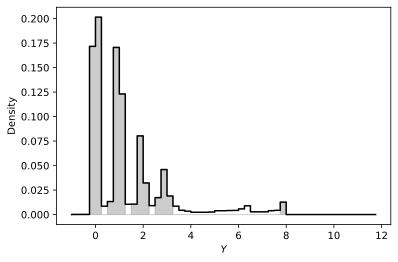

In [7]:
from chr.grey_boxes import HistogramAccumulator

# Initialize density accumulator (grey-box)
accumulator = HistogramAccumulator(histogram_test, grid_histogram, alpha=0.1, delta_alpha=0.01)

# Desired level
alpha = 0.1

# Generate noise for randomization
epsilon = np.random.uniform(low=0.0, high=1.0, size=X_test.shape[0])

# Compute randomized sets
S = accumulator.predict_sets(alpha, epsilon=epsilon)

# Plot the conditional density and the prediction sets
plot_histogram(grid_histogram, histogram_test, S, i=i_plot)

In [8]:
# Compute randomized sets
S, _ = accumulator.predict_intervals(alpha, epsilon=epsilon)

Now we will consider the case of prediction intervals.

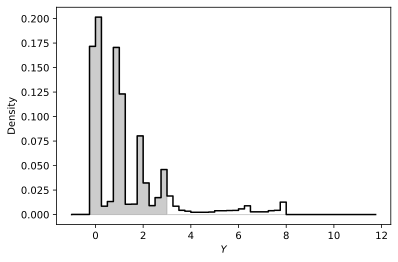

In [9]:
# Plot the conditional density and the prediction intervals
S_int = [np.arange(S[i][0],S[i][1]+1) for i in range(len(S))]
plot_histogram(grid_histogram, histogram_test, S_int, i=i_plot)

We can compare our prediction interval with the symmetric [5%, 95%] interval.

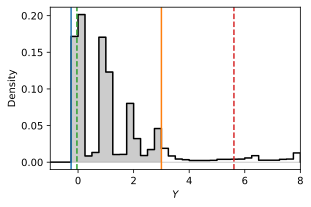

In [11]:
idx_5 = np.where(np.abs(grid_quantiles-0.05)<1e-6)[0]
idx_95 = np.where(np.abs(grid_quantiles-0.95)<1e-6)[0]
intervals_symmetric = np.concatenate((Q_test[:, idx_5],Q_test[:, idx_95]),1)

S_int = [np.arange(S[i][0],S[i][1]+1) for i in range(len(S))]
intervals_crch = np.array([[grid_histogram[S_int[i]-1][0],grid_histogram[S_int[i]][-1]] for i in range(len(S_int))])

from chr.utils import plot_histogram

plot_histogram(grid_histogram, histogram_test, S_int, 
               limits=np.concatenate([intervals_crch,intervals_symmetric],1), 
               colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
               linestyles = ['-','-','--','--'],
               i=i_plot, 
               xlim = [-1,8],
               filename="histogram.pdf")

## Visualizing the prediction bands

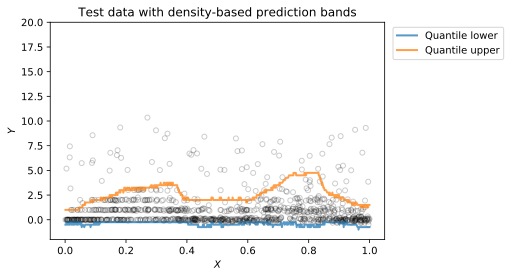

In [12]:
S, bands = accumulator.predict_intervals(alpha, epsilon=epsilon)

plot_func(X_test[:,0], Y_test, quantiles=bands, quantile_labels=["lower", "upper"], 
          title="Test data with density-based prediction bands")

## Computing conformity scores

Conformity scores for general prediction sets can be computed in closed form exactly as in the classification paper.
Conformity scores for contiguous intervals need to be computed numerically.

In [13]:
scores = accumulator.calibrate_intervals(Y_test, epsilon=epsilon)

Computing conformity scores.


  0%|          | 0/99 [00:00<?, ?it/s]

If the conditional density is well-calibrated, these scores should be uniformly distributed. Stochastically larger scores mean that we need to be more conservative (compared to an oracle) in order to have the correct coverage.

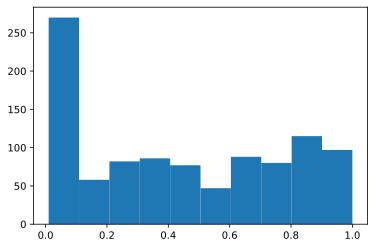

0.9000000000000001

In [14]:
plt.hist(scores)
plt.show()

from scipy.stats.mstats import mquantiles
mquantiles(scores, prob=0.9)[0]

## Split-conformal calibration

Split-conformal with pre-trained black box

In [15]:
from chr.methods import CHR

# Split the data
X_train, X_calib, Y_train, Y_calib = train_test_split(X_data, Y_data, test_size=0.5, random_state=2020)

# Initialize the black-box
grid_quantiles = np.arange(0.01,1.0,0.01)
bbox = QNet(grid_quantiles, 1, no_crossing=True, batch_size=1000, dropout=0.1,
            num_epochs=10000, learning_rate=0.0005, num_hidden=256, calibrate=0)

# Pre-train the black-box
bbox.fit(X_train, Y_train)

Training with 1000 samples and 1 features.


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
# Initialize and calibrate the new method
chr = CHR(bbox, ymin=-3, ymax=20, y_steps=200, delta_alpha=0.001, randomize=True)
chr.calibrate(X_calib, Y_calib, alpha)

Computing conformity scores.


  0%|          | 0/999 [00:00<?, ?it/s]

Calibrated alpha (nominal level: 0.1): 0.102.


0.1015

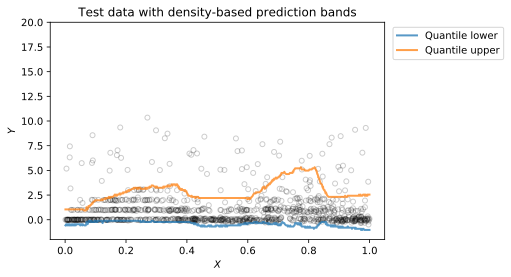

In [17]:
bands = chr.predict(X_test)

plot_func(X_test[:,0], Y_test, quantiles=bands, quantile_labels=["lower", "upper"], 
          title="Test data with density-based prediction bands")

In [18]:
from chr.utils import evaluate_predictions

print(evaluate_predictions(bands, Y_test, X=X_test))

   Coverage  Conditional coverage    Length  Length cover
0     0.921              0.910112  3.281256      3.281256


## Comparison with CQR

In [19]:
from chr.others import CQR

qnet_simple = QNet([0.05,0.95], 1, no_crossing=True, batch_size=X_train.shape[0], dropout=0,
                   num_epochs=1000, learning_rate=0.01, calibrate=False)
cqr = CQR(qnet_simple)

scores = cqr.fit_calibrate(X_data, Y_data, alpha)

Training with 1000 samples and 1 features.


  0%|          | 0/1000 [00:00<?, ?it/s]

Calibrated score corrections: 0.001, -0.001


CQR with pre-trained black-box

In [20]:
from chr.others import CQR

# Initialize black-box and conformalizer
cqr = CQR(bbox)

# Calibrate the conformalizer
cqr.calibrate(X_calib, Y_calib, alpha)

Calibrated score corrections: 0.005, -0.005


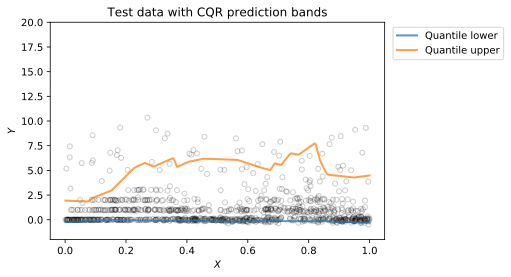

   Coverage  Conditional coverage    Length  Length cover
0     0.903              0.859155  5.130246      5.130247


In [21]:
bands_cqr = cqr.predict(X_test)

plot_func(X_test[:,0], Y_test, quantiles=bands_cqr, quantile_labels=["lower", "upper"], 
          title="Test data with CQR prediction bands")

print(evaluate_predictions(bands_cqr, Y_test, X=X_test))

## Plots for paper

<Figure size 432x288 with 0 Axes>

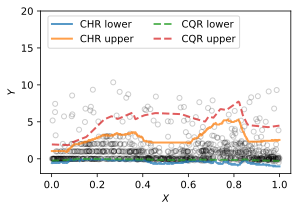

In [22]:
fig = plt.figure()

def make_plots(x, y, limits=None, limit_labels=None, limit_styles=None, max_show=5000, filename=None):
    x_ = x[:max_show]
    y_ = y[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds], y_[inds], 'k.', alpha=.2, markersize=10, fillstyle='none')

    if limits is not None:
        num_limits = limits.shape[1]
    else:
        num_limits = 0  
    
    if limit_styles is None:
        limit_styles = ['-'] * num_limits
    
    if limit_labels is None:
        pred_labels = ["NA"] * num_limits
    for k in range(num_limits):
        label_txt = '{q}'.format(q=limit_labels[k])
        plt.plot(x_[inds], limits[inds,k], limit_styles[k], lw=2, alpha=0.75, label=label_txt)
    
    plt.ylim([-2, 20])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', ncol=2)
    
    if filename is not None:
        fig.set_size_inches(4.5, 3)
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        
    plt.show()
    
make_plots(X_test[:,0], Y_test, 
           limits=np.concatenate([bands, bands_cqr],1), 
           limit_labels=["CHR lower", "CHR upper", "CQR lower", "CQR upper"],
           limit_styles=['-','-','--','--'],
           filename="bands_comparison.pdf")